Hallo, ini merupakan salah satu project saya mengikuti kegiatan Studi Independen tahun 2022 di Zenius dengan modul Data Warehousing, Analysis, and Visualization for Business Insights. 
Kali ini merupakan project machine learning untuk melakukan prediksi kasus penipuan (fraud) pada jenis transaksi dengan kartu kredit atau biasa disbut dengan transaction fraud

In [39]:

import pandas as pd
from pandas_profiling import ProfileReport as PR
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import gc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix,confusion_matrix, classification_report

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import metrics

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.tree import DecisionTreeClassifier 
from sklearn.impute import KNNImputer

import joblib

from imblearn.over_sampling import SMOTENC

from catboost import CatBoostClassifier, Pool

import shap

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [3]:
dt = pd.read_csv('/kaggle/input/transaction-fraud/transactions2.csv')
dt.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
0,733493772,5000,5000.00,2016-01-08 19:04:50,111.33,Lyft,US,US,5,1,...,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,0.00,False,False
1,733493772,5000,4888.67,2016-01-09 22:32:39,24.75,Uber,US,US,9,1,...,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,111.33,False,False
2,733493772,5000,4863.92,2016-01-11 13:36:55,187.40,Lyft,US,US,5,1,...,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,136.08,False,False
3,733493772,5000,4676.52,2016-01-11 22:47:46,227.34,Lyft,US,US,2,1,...,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,323.48,False,False
4,733493772,5000,4449.18,2016-01-16 01:41:11,0.00,Lyft,US,US,2,1,...,2014-08-03,2014-08-03,492,492,9184,ADDRESS_VERIFICATION,False,550.82,False,False


# Data Handling

**Checking missing values**

In [4]:
dt.isnull().sum()

customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
isFraud                     0
currentBalance              0
cardPresent                 0
expirationDateKeyInMatch    0
dtype: int64

**checking duplicate rows**

In [5]:
# Checking duplicated rows

dt.duplicated().sum()

0

**Change features data type**

In [6]:
#mengubah tipedata kolom object yang seharusnya datetime

dt['transactionDateTime'] = pd.to_datetime(dt['transactionDateTime'], infer_datetime_format=True)
dt['currentExpDate'] = pd.to_datetime(dt['currentExpDate'], infer_datetime_format=True)
dt['accountOpenDate'] = pd.to_datetime(dt['accountOpenDate'], infer_datetime_format=True)
dt['dateOfLastAddressChange'] = pd.to_datetime(dt['dateOfLastAddressChange'], infer_datetime_format=True)

**remove unnecessary features**

In [7]:
dt.drop(['transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange','enteredCVV','cardLast4Digits'],axis=1, inplace=True)

In [8]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641914 entries, 0 to 641913
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customerId                641914 non-null  int64  
 1   creditLimit               641914 non-null  int64  
 2   availableMoney            641914 non-null  float64
 3   transactionAmount         641914 non-null  float64
 4   merchantName              641914 non-null  object 
 5   acqCountry                641914 non-null  object 
 6   merchantCountryCode       641914 non-null  object 
 7   posEntryMode              641914 non-null  int64  
 8   posConditionCode          641914 non-null  int64  
 9   merchantCategoryCode      641914 non-null  object 
 10  cardCVV                   641914 non-null  int64  
 11  transactionType           641914 non-null  object 
 12  isFraud                   641914 non-null  bool   
 13  currentBalance            641914 non-null  f

**Grouping features**

In [9]:
# Group column names based on type
cats = ['customerId','merchantName','acqCountry','merchantCountryCode','merchantCategoryCode','transactionType','isFraud','cardPreent','expirationDateKeyInMatch']
nums = ['creditLimit','availableMoney','transactionAmount','posEntryMode','posConditionCode','cardCVV','currentBalance']

#  Exploratory Data Analysis

**view summary of dataset**

In [10]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641914 entries, 0 to 641913
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customerId                641914 non-null  int64  
 1   creditLimit               641914 non-null  int64  
 2   availableMoney            641914 non-null  float64
 3   transactionAmount         641914 non-null  float64
 4   merchantName              641914 non-null  object 
 5   acqCountry                641914 non-null  object 
 6   merchantCountryCode       641914 non-null  object 
 7   posEntryMode              641914 non-null  int64  
 8   posConditionCode          641914 non-null  int64  
 9   merchantCategoryCode      641914 non-null  object 
 10  cardCVV                   641914 non-null  int64  
 11  transactionType           641914 non-null  object 
 12  isFraud                   641914 non-null  bool   
 13  currentBalance            641914 non-null  f

In [11]:
def summary_tab(df):
  summary = pd.DataFrame({
      'Kolom': df.columns,
      'dataType': df.dtypes,
      'null' : df.isna().sum(),
      'null_percentage' : round(df.isna().sum()/len(df)*100,2),
      'unique' : df.nunique(),
      'unique_sample' : [list(df[i].drop_duplicates().sample(2)) for i in df.columns]
  })
  summary['unique_%'] = round(summary['unique'] / len(df) * 100,2)
  return summary.reset_index(drop=True)

In [12]:
summary_tab(dt)


,Kolom,dataType,null,null_percentage,unique,unique_sample,unique_%
0,customerId,int64,0,0.0,5000,"[745032042, 326889731]",0.78
1,creditLimit,int64,0,0.0,10,"[20000, 250]",0.00
2,availableMoney,float64,0,0.0,450648,"[10024.29, 1664.13]",70.20
3,transactionAmount,float64,0,0.0,62735,"[380.54, 181.94]",9.77
4,merchantName,object,0,0.0,2493,"[Domino's Pizza #643011, Krispy Kreme #563567]",0.39
5,acqCountry,object,0,0.0,4,"[PR, CAN]",0.00
6,merchantCountryCode,object,0,0.0,4,"[US, CAN]",0.00
7,posEntryMode,int64,0,0.0,5,"[9, 5]",0.00
8,posConditionCode,int64,0,0.0,3,"[99, 8]",0.00
9,merchantCategoryCode,object,0,0.0,19,"[online_gifts, auto]",0.00


**View Dimension of data**

In [13]:
# view dimension of data
dt.shape

(641914, 16)

diketahui bahwa jumlah baris data adalah 641914 dengan 22 kolom

**View top 5 of data**

In [14]:
dt.head()

,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardCVV,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
0,733493772,5000,5000.00,111.33,Lyft,US,US,5,1,rideshare,492,PURCHASE,True,0.00,False,False
1,733493772,5000,4888.67,24.75,Uber,US,US,9,1,rideshare,492,PURCHASE,False,111.33,False,False
2,733493772,5000,4863.92,187.40,Lyft,US,US,5,1,rideshare,492,PURCHASE,False,136.08,False,False
3,733493772,5000,4676.52,227.34,Lyft,US,US,2,1,rideshare,492,PURCHASE,True,323.48,False,False
4,733493772,5000,4449.18,0.00,Lyft,US,US,2,1,rideshare,492,ADDRESS_VERIFICATION,False,550.82,False,False


**Statistik deskriptif**

In [15]:
dt.describe()

,customerId,creditLimit,availableMoney,transactionAmount,posEntryMode,posConditionCode,cardCVV,currentBalance
count,6.419140e+05,641914.000000,641914.000000,641914.000000,641914.000000,641914.000000,641914.000000,641914.000000
mean,5.547701e+08,10697.210608,6652.828573,135.162497,9.114905,3.237367,557.199927,4044.382035
std,2.546884e+08,11460.359133,9227.132275,147.053302,16.919556,9.678814,257.326204,5945.510224
min,1.005471e+08,250.000000,-1244.930000,0.000000,2.000000,1.000000,100.000000,0.000000
25%,3.223192e+08,5000.000000,1114.970000,32.320000,2.000000,1.000000,334.000000,502.442500
50%,5.438879e+08,7500.000000,3578.165000,85.800000,5.000000,1.000000,581.000000,2151.860000
75%,7.862277e+08,15000.000000,8169.185000,189.030000,9.000000,1.000000,762.000000,5005.890000
max,9.999853e+08,50000.000000,50000.000000,1825.250000,90.000000,99.000000,998.000000,47496.500000


In [16]:
dt.describe(include=['object','bool'])

,merchantName,acqCountry,merchantCountryCode,merchantCategoryCode,transactionType,isFraud,cardPresent,expirationDateKeyInMatch
count,641914,641914,641914,641914,641914,641914,641914,641914
unique,2493,4,4,19,3,2,2,2
top,Lyft,US,US,online_retail,PURCHASE,False,False,False
freq,25311,636216,636201,161469,609274,630612,340453,640945


**Correlation plot**

In [17]:
import matplotlib.pyplot as plt

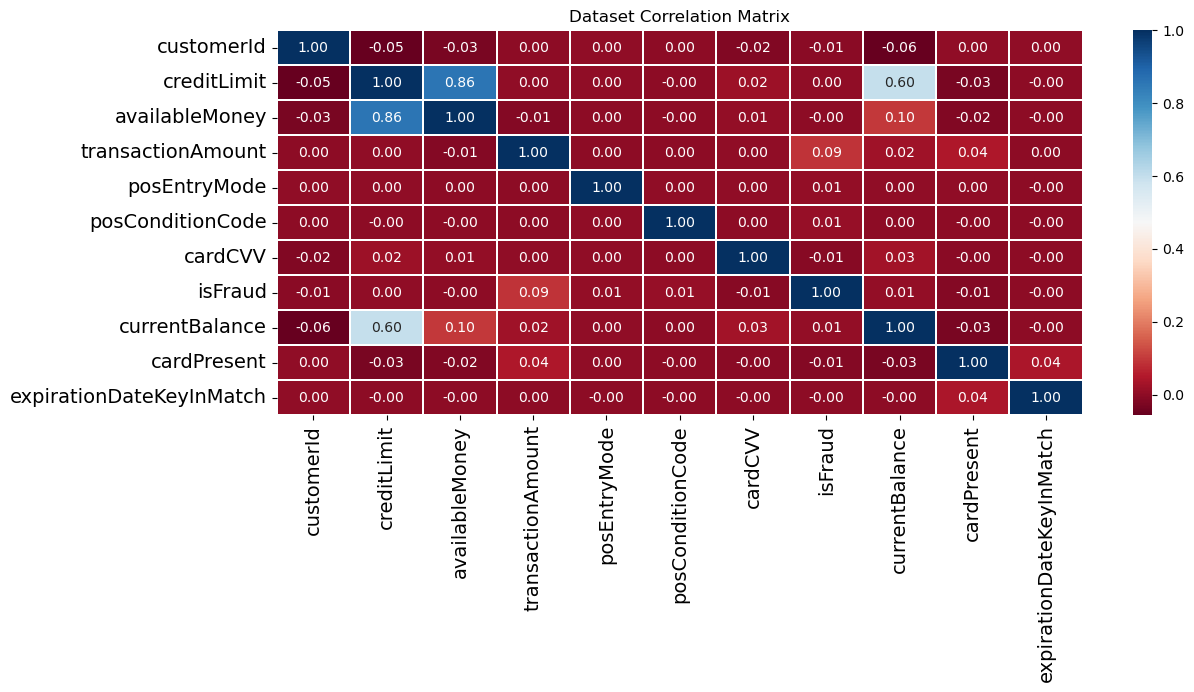

In [18]:
# plot correlation matrix heatmap
fig, ax = plt.subplots(figsize=[13,5])
sns.heatmap(dt.corr(), ax=ax,  annot=True, linewidths=0.05, fmt= '.2f',cmap='RdBu')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('Dataset Correlation Matrix')
fig.show()

Tidak ada yang perlu dihapus

**Univariate Analysis**

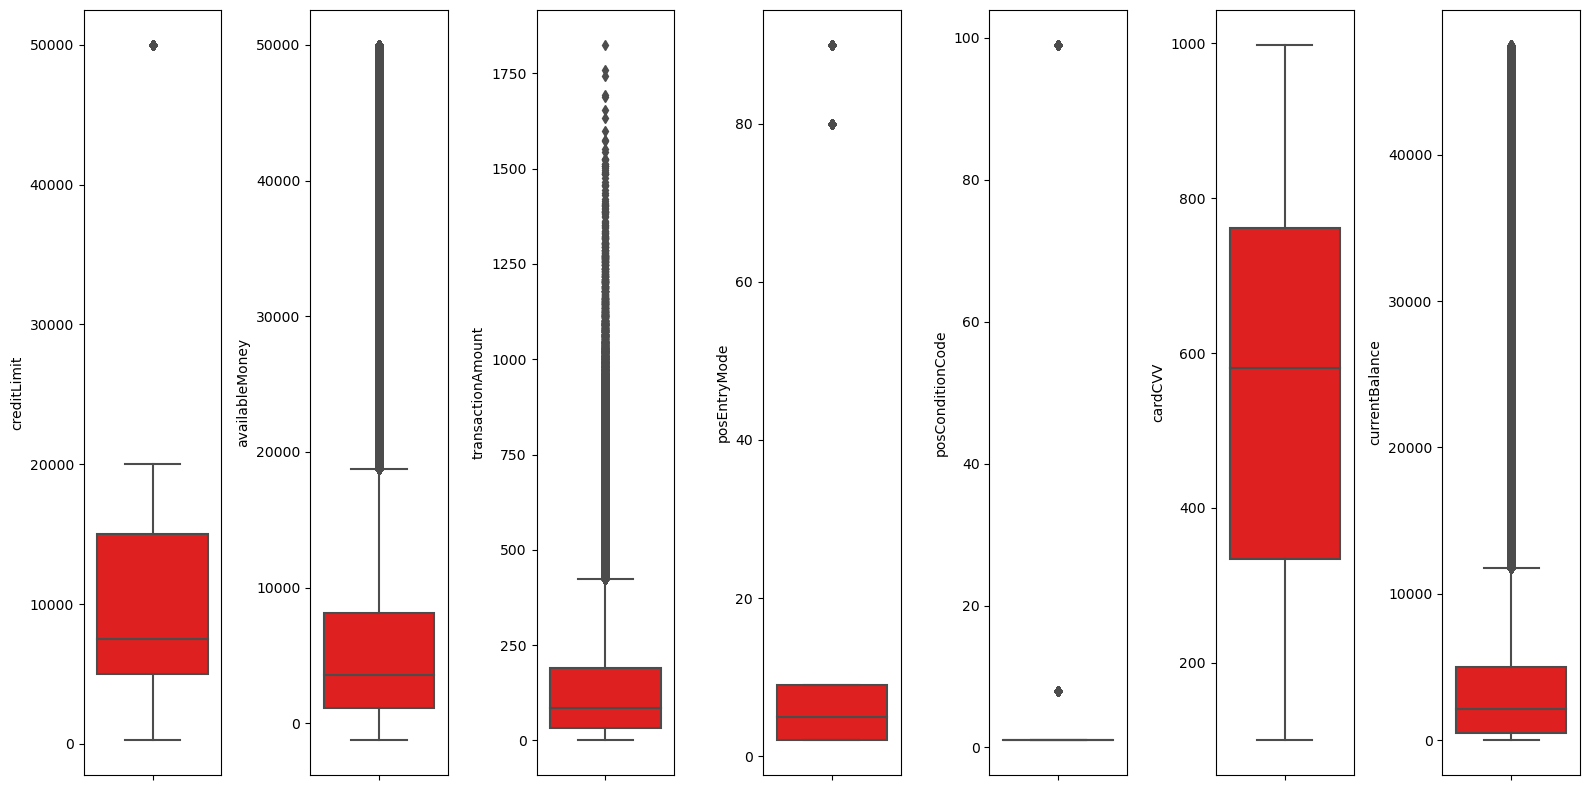

In [19]:
# adjust the figure size for better readability
plt.figure(figsize=(16,8))
# plotting
features = nums
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=dt[features[i]], color='red')
    plt.tight_layout()


plt.show()

Outlier tidak perlu ditangani, dikarenakan bukan kesalahan dari proses import data melainkan murni data dari pengguna.

<AxesSubplot:xlabel='isFraud', ylabel='count'>

<Figure size 640x480 with 0 Axes>

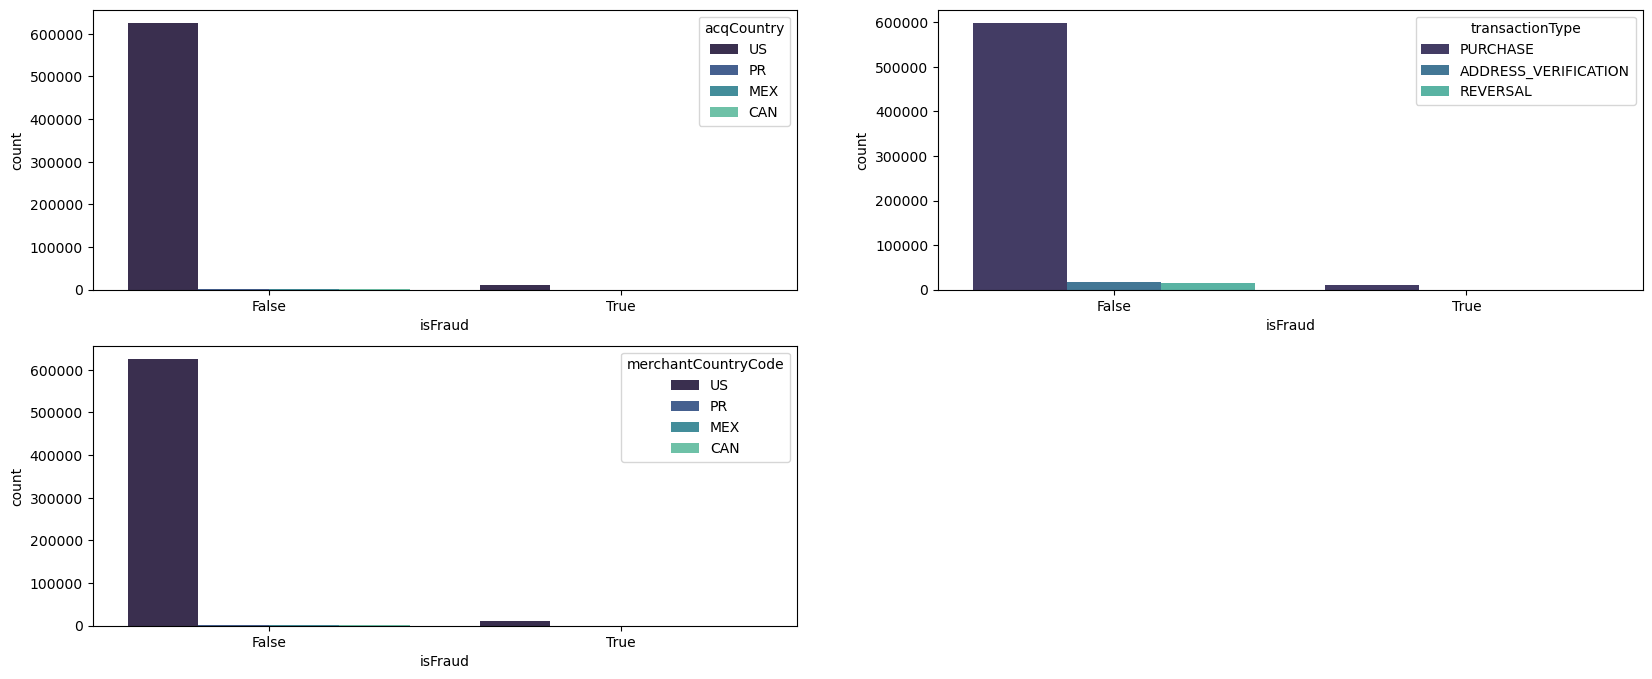

In [20]:
plt.figure(1)
plt.figure(figsize=(20,8))

# segment affect Account Country
plt.subplot(221)
sns.countplot(data=dt, x='isFraud',
              hue = 'acqCountry',palette='mako')

# segment affect Transaction Type
plt.subplot(222)
sns.countplot(data=dt, x='isFraud',
              hue = 'transactionType',palette='mako')

# segment affect Merchant Country Code
plt.subplot(223)
sns.countplot(data=dt, x='isFraud',
              hue = 'merchantCountryCode',palette='mako')



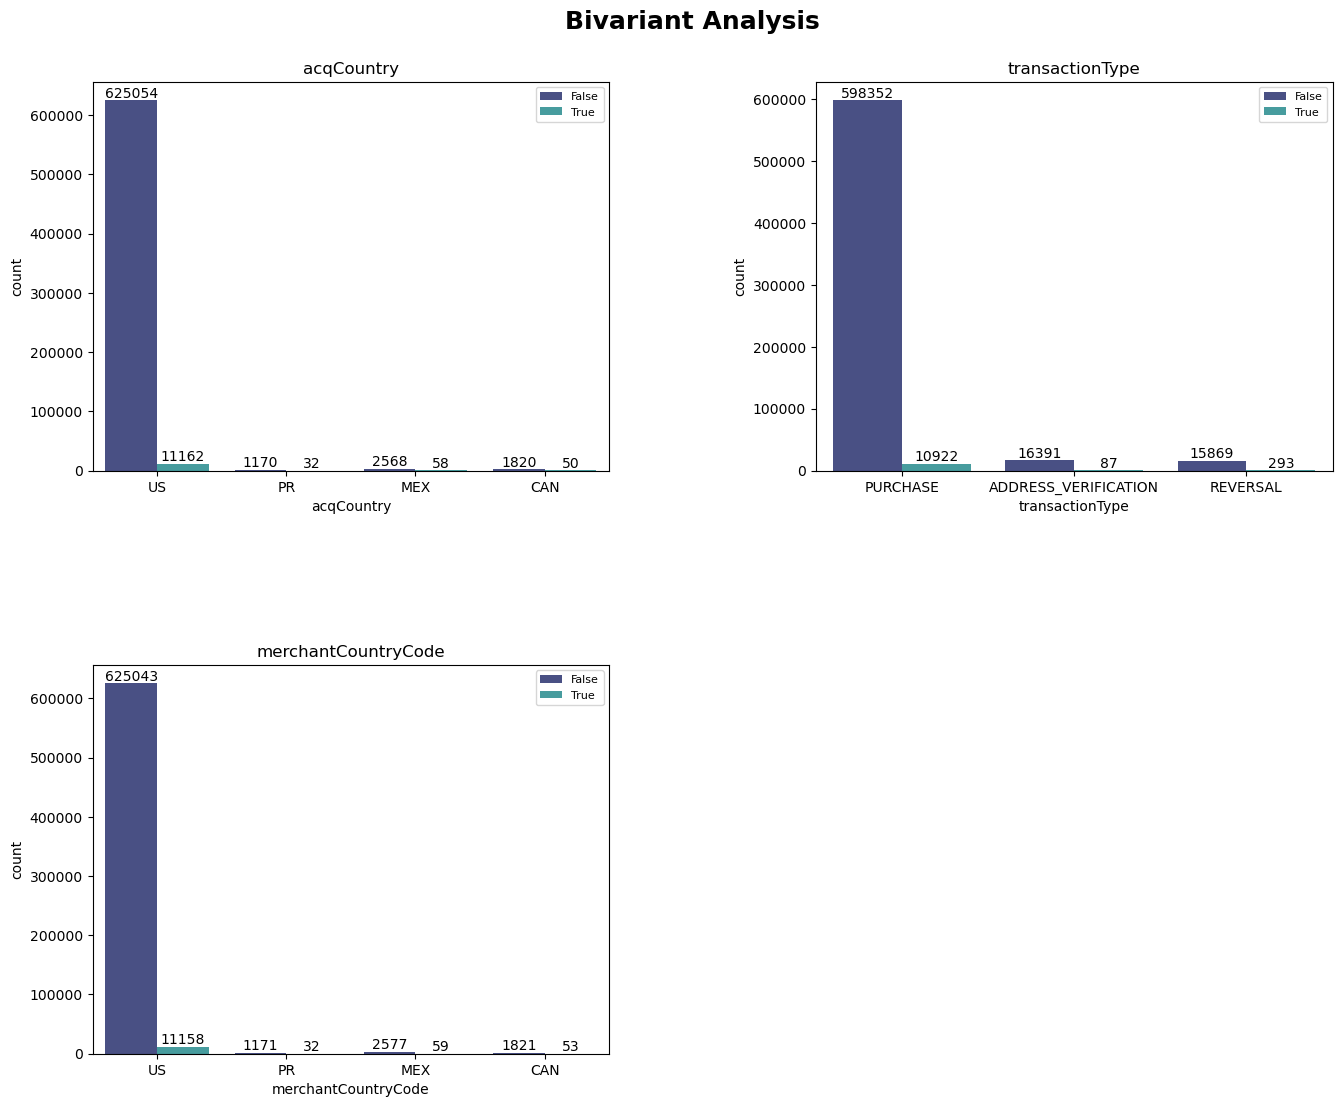

In [21]:
#create figure with 3 x 3 grid of subplots
fig = plt.figure(figsize=[16,12])
fig.suptitle('Bivariant Analysis', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(['acqCountry','transactionType','merchantCountryCode']):
    a = fig.add_subplot(2, 2, i+1)
    a=sns.countplot(x = dt[col] , ax=a , hue = dt['isFraud'],palette='mako' )
    a.set_title(col)
    a.bar_label(a.containers[0] ) 
    a.bar_label(a.containers[1] )
    a.legend(fontsize=8)

*Total customer by Country*

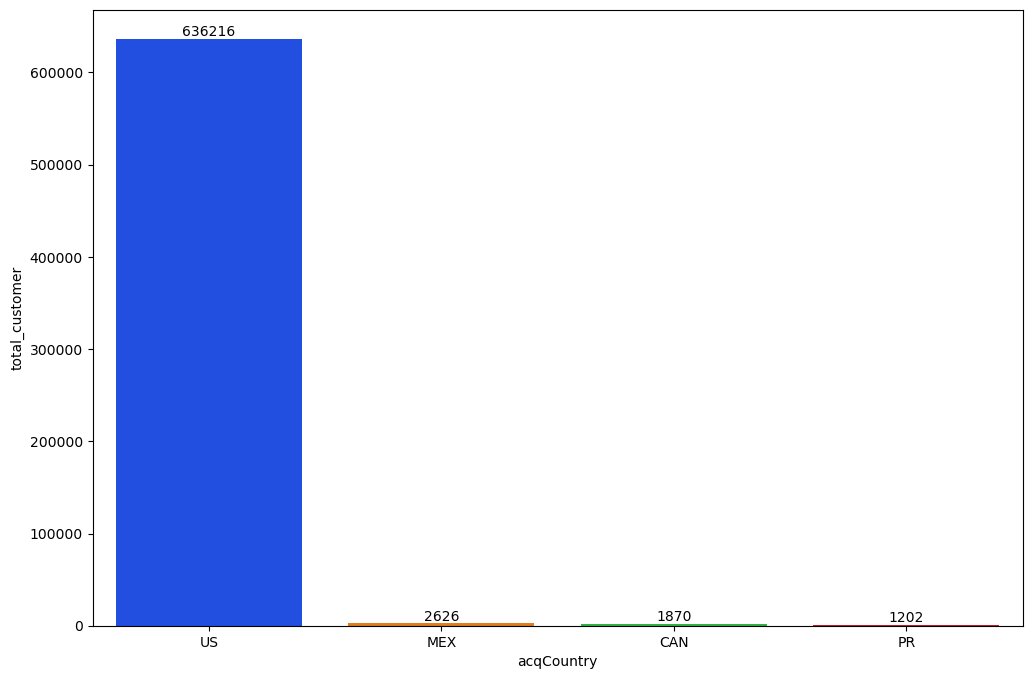

In [22]:
plot = (dt.groupby('acqCountry')
     .agg(total_customer=('customerId', 'count'))
     .sort_values('total_customer', ascending=0)
     .head(10)
     .reset_index())

# Visualize 
plt.figure(figsize=(12,8))
a= sns.barplot(data=plot, x='acqCountry', y='total_customer', palette='bright')
a.bar_label(a.containers[0])
plt.show()

*Total transaction amount by Merchant Name*

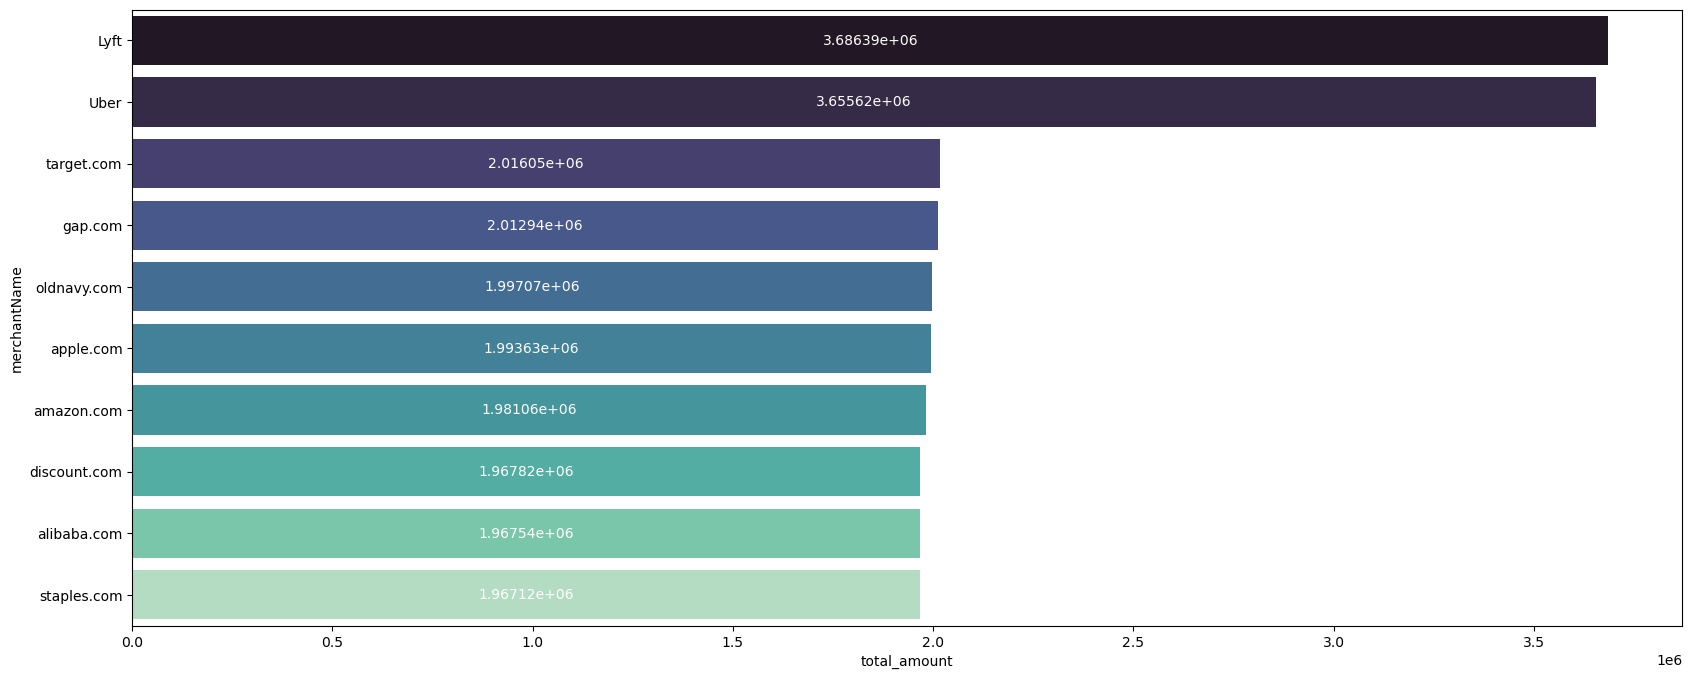

In [23]:
plot2 = (dt.groupby('merchantName')
       .agg(total_amount=('transactionAmount', 'sum'))
       .reset_index()
       .sort_values('total_amount', ascending=False)
        .head(10))

# Visualize
plt.figure(figsize=(20,8))
a=sns.barplot(data=plot2, x='total_amount', y='merchantName', palette='mako')
a.bar_label(a.containers[0],label_type='center',color='white')
plt.show()

*Total transaction amount by Merchant Category*


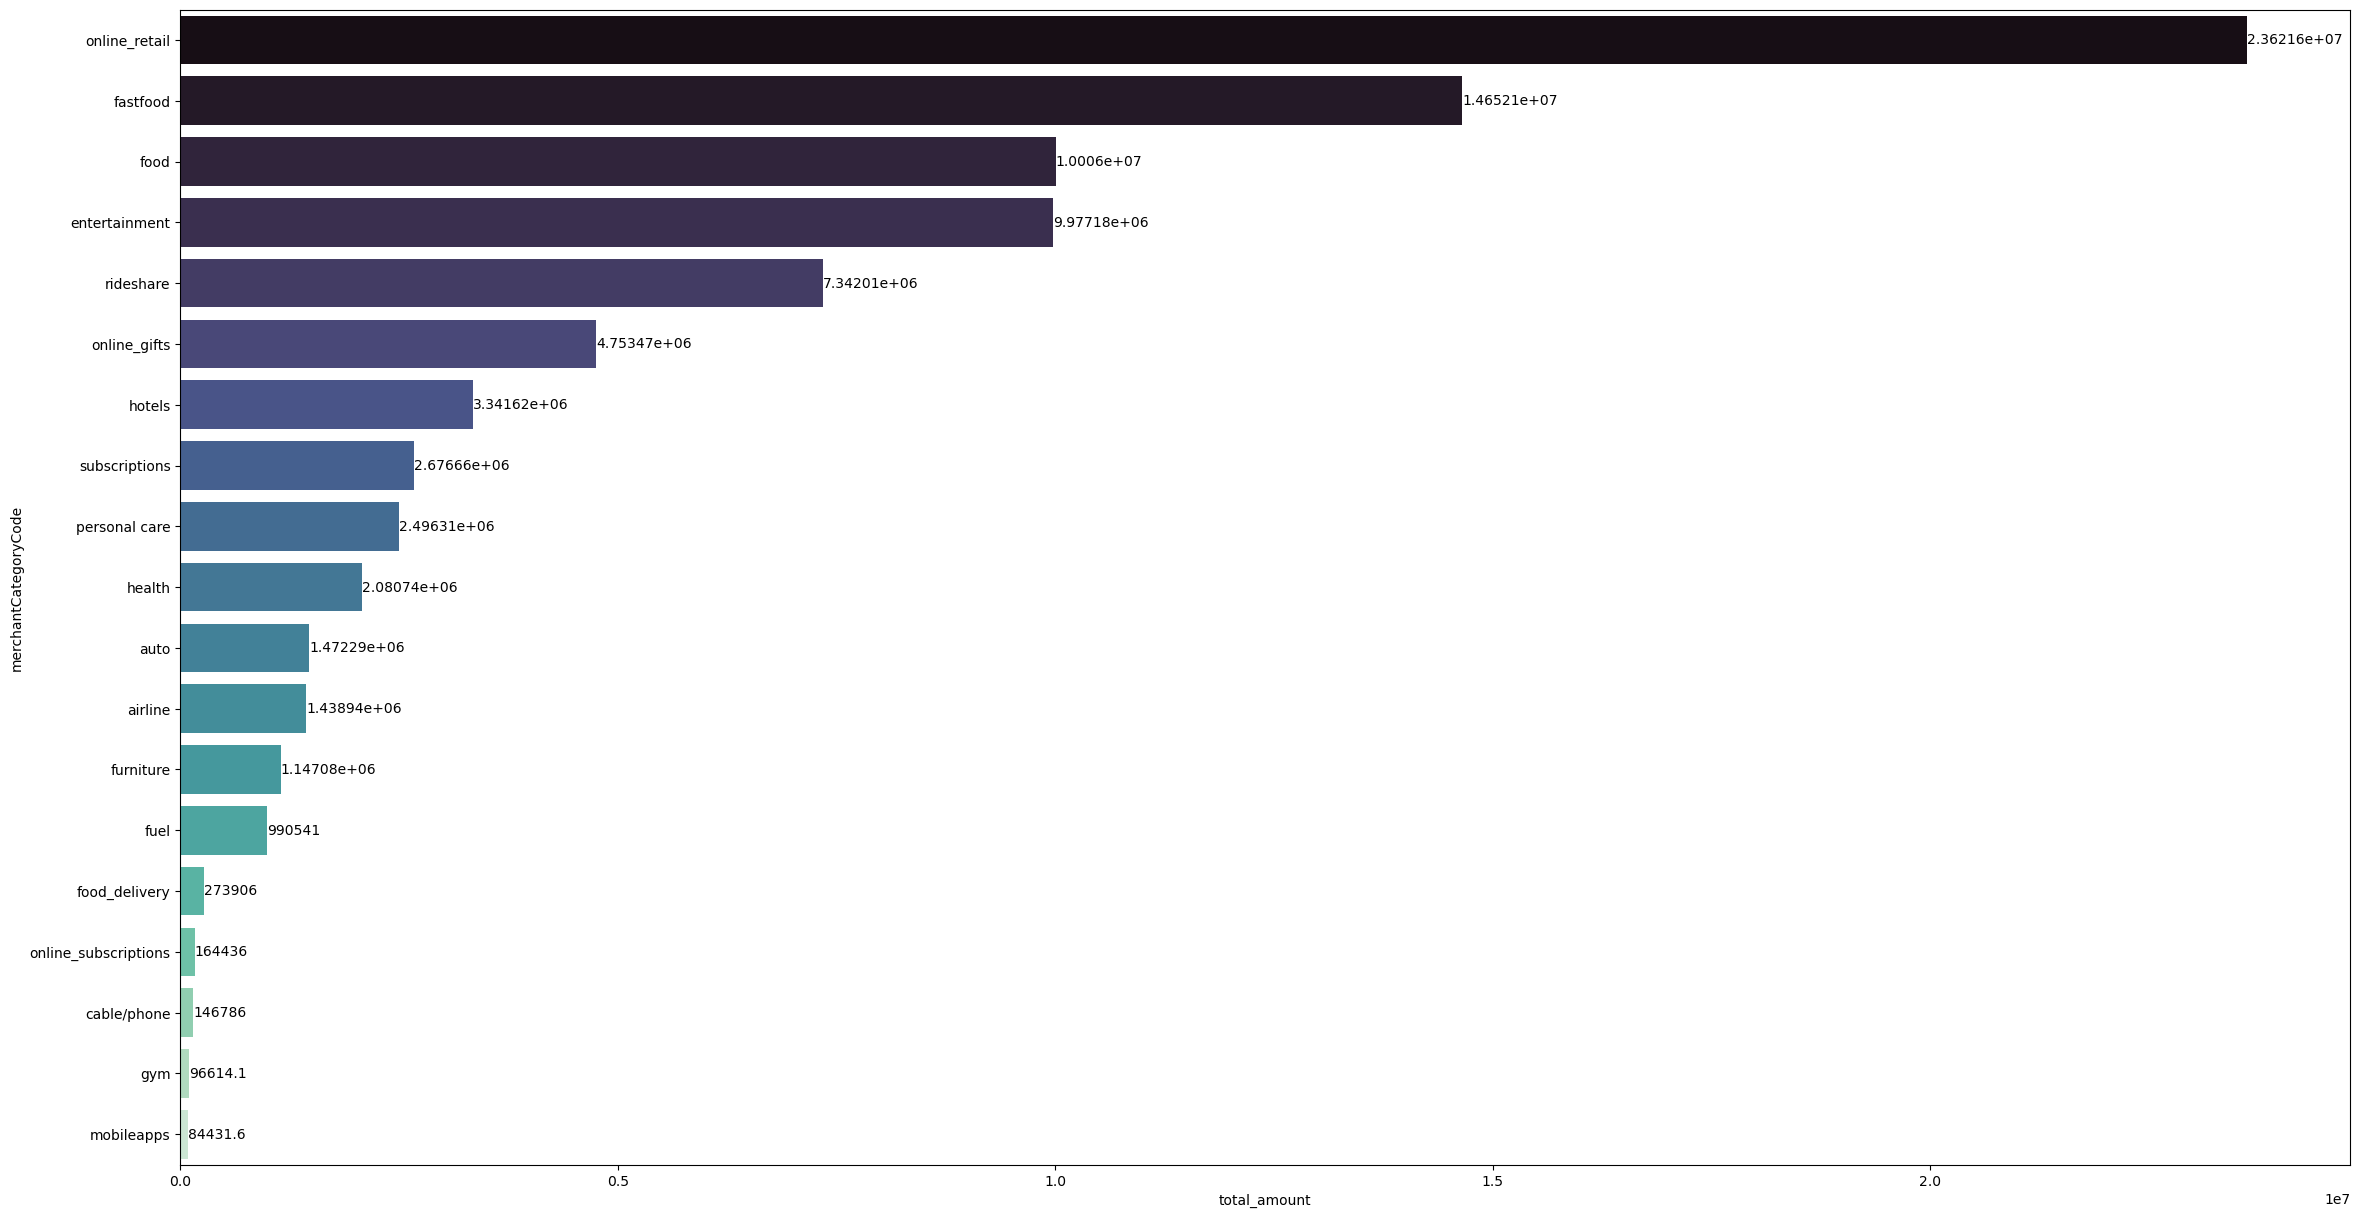

In [24]:
plot3 = (dt.groupby('merchantCategoryCode')
       .agg(total_amount=('transactionAmount', 'sum'))
       .reset_index()
       .sort_values('total_amount', ascending=False))

# Visualize
plt.figure(figsize=(28,15))
a=sns.barplot(data=plot3, x='total_amount', y='merchantCategoryCode', palette='mako')
a.bar_label(a.containers[0],color='black')

plt.show()

*Total transaction amount by Transaction Type*

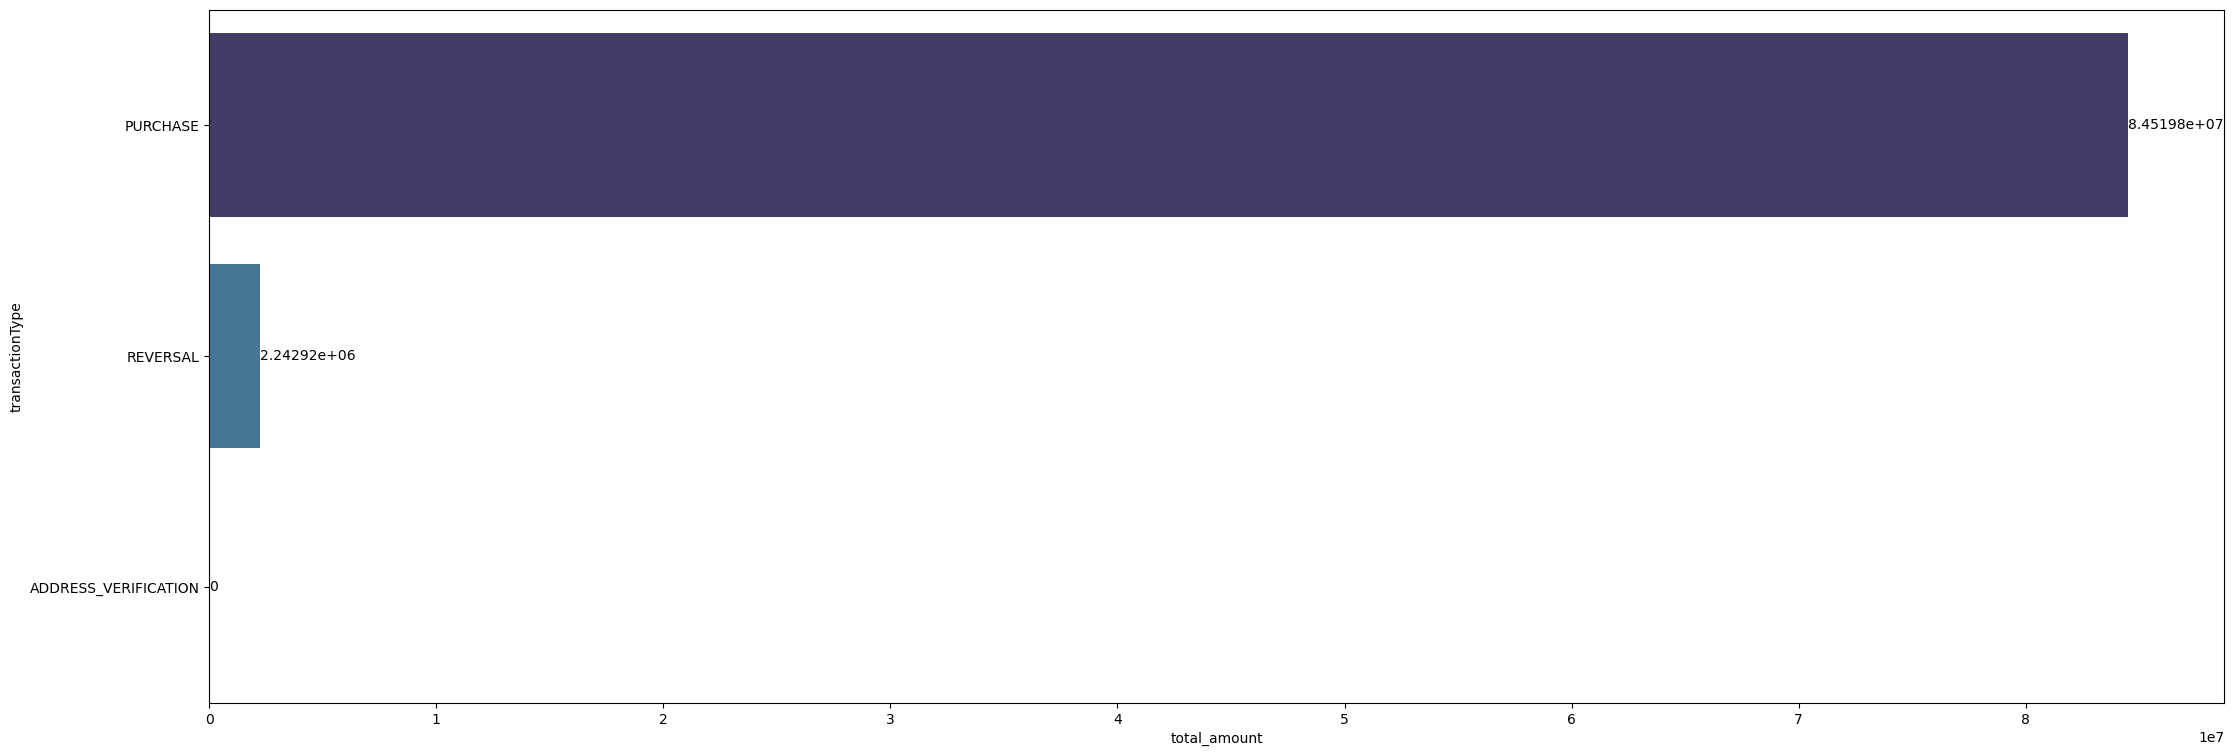

In [25]:
plot4 = (dt.groupby('transactionType')
       .agg(total_amount=('transactionAmount', 'sum'))
       .reset_index()
       .sort_values('total_amount', ascending=False)
       .head(10))

# Visualize
plt.figure(figsize=(26,9))
a=sns.barplot(data=plot4, x='total_amount', y='transactionType', palette='mako')
a.bar_label(a.containers[0],color='black')
plt.show()

# Data Preparation


Seringkali, algoritma pembelajaran statistik tidak dapat diterapkan secara langsung. Data harus dieprsiapkan terlebih dahulu sebelum dilakukan modelling

**Drop unecessary features**

In [26]:
dt1 = dt.copy()
dt1.drop(['customerId'],axis=1,inplace=True)


**Changes data type bool to object**


In [27]:
dt1['isFraud']=dt1['isFraud'].astype('object')
dt1['cardPresent']=dt1['cardPresent'].astype('object')
dt1['expirationDateKeyInMatch']=dt1['expirationDateKeyInMatch'].astype('object')

In [29]:
dt1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641914 entries, 0 to 641913
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   creditLimit               641914 non-null  int64  
 1   availableMoney            641914 non-null  float64
 2   transactionAmount         641914 non-null  float64
 3   merchantName              641914 non-null  object 
 4   acqCountry                641914 non-null  object 
 5   merchantCountryCode       641914 non-null  object 
 6   posEntryMode              641914 non-null  int64  
 7   posConditionCode          641914 non-null  int64  
 8   merchantCategoryCode      641914 non-null  object 
 9   cardCVV                   641914 non-null  int64  
 10  transactionType           641914 non-null  object 
 11  isFraud                   641914 non-null  object 
 12  currentBalance            641914 non-null  float64
 13  cardPresent               641914 non-null  o

## Feature Engineering

Dalam beberapa model, nilai dalai features harus berupa nilai dengan sehingga dilakukan perubahan pada data bersifat kategorik atau boolean

In [30]:
dt1.head()

,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardCVV,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
0,5000,5000.00,111.33,Lyft,US,US,5,1,rideshare,492,PURCHASE,True,0.00,False,False
1,5000,4888.67,24.75,Uber,US,US,9,1,rideshare,492,PURCHASE,False,111.33,False,False
2,5000,4863.92,187.40,Lyft,US,US,5,1,rideshare,492,PURCHASE,False,136.08,False,False
3,5000,4676.52,227.34,Lyft,US,US,2,1,rideshare,492,PURCHASE,True,323.48,False,False
4,5000,4449.18,0.00,Lyft,US,US,2,1,rideshare,492,ADDRESS_VERIFICATION,False,550.82,False,False


In [31]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#object_col = [col for col in df.columns if df[col].dtypes == 'object']
#for col in object_col:
for col in [col for col in dt1.columns if dt1[col].dtypes == 'object']:
    dt1[col] = le.fit_transform(dt1[col].astype(str))
dt1.head()

,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardCVV,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
0,5000,5000.00,111.33,1066,3,3,5,1,17,492,1,1,0.00,0,0
1,5000,4888.67,24.75,2086,3,3,9,1,17,492,1,0,111.33,0,0
2,5000,4863.92,187.40,1066,3,3,5,1,17,492,1,0,136.08,0,0
3,5000,4676.52,227.34,1066,3,3,2,1,17,492,1,1,323.48,0,0
4,5000,4449.18,0.00,1066,3,3,2,1,17,492,0,0,550.82,0,0


## Feature Scaling

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

dt1['creditLimit'] = scaler.fit_transform(dt1['creditLimit'].values.reshape(len(dt1),1))
dt1['availableMoney'] = scaler.fit_transform(dt1['availableMoney'].values.reshape(len(dt1),1))
dt1['transactionAmount'] = scaler.fit_transform(dt1['transactionAmount'].values.reshape(len(dt1),1))
dt1['cardCVV'] = scaler.fit_transform(dt1['cardCVV'].values.reshape(len(dt1),1))
dt1['currentBalance'] = scaler.fit_transform(dt1['currentBalance'].values.reshape(len(dt1),1))

In [33]:
dt1.head()

,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardCVV,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
0,0.095477,0.121864,0.060994,1066,3,3,5,1,17,0.436526,1,1,0.000000,0,0
1,0.095477,0.119692,0.013560,2086,3,3,9,1,17,0.436526,1,0,0.002344,0,0
2,0.095477,0.119209,0.102671,1066,3,3,5,1,17,0.436526,1,0,0.002865,0,0
3,0.095477,0.115552,0.124553,1066,3,3,2,1,17,0.436526,1,1,0.006811,0,0
4,0.095477,0.111116,0.000000,1066,3,3,2,1,17,0.436526,0,0,0.011597,0,0


## Data Split

In [34]:
X = dt1.drop(['isFraud'], axis = 1)
y = dt1['isFraud']

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20,random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Val set:', X_val.shape,  y_val.shape)

Train set: (513531, 14) (513531,)
Val set: (128383, 14) (128383,)


# Creating Model

Pada kesempatan kali ini akan dibentuk jenis model:
 
 - Support Vector Machine
 - K-Nearest Neighbors
 - Random Forest
 - Decision Tree

**Support Vector Machine**

**K-Nearest Neighbors**

In [35]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
tree_pred = knn.predict(X_val)

#Evaluation
precision_tree = metrics.accuracy_score(tree_pred, y_val) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision_tree))

# calculate the FPR and TPR for all thresholds of the classification
probs = knn.predict_proba(X_val)
probs = probs[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_val, probs)
knn_auc = metrics.roc_auc_score(y_val, probs)

Accuracy with K-NN: 98.17%


**Random Forest**

In [37]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train) 
rfc_pred = rfc.predict(X_val)

#Evaluation
precision_rfc = metrics.accuracy_score(rfc_pred, y_val) * 100
print("Accuracy with Random Forest: {0:.2f}%".format(precision_rfc))

# calculate the FPR and TPR for all thresholds of the classification
probs = rfc.predict_proba(X_val)
probs = probs[:, 1]
rfc_fpr, rfc_tpr, thresholds = metrics.roc_curve(y_val, probs)
rfc_auc = metrics.roc_auc_score(y_val, probs)


Accuracy with Random Forest: 98.26%


**Decision Tree**

In [40]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train,y_train)
tree_pred = tree.predict(X_val)

#Evaluation
precision_tree = metrics.accuracy_score(tree_pred, y_val) * 100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision_tree))

# calculate the FPR and TPR for all thresholds of the classification
probs = tree.predict_proba(X_val)
probs = probs[:, 1]
tree_fpr, tree_tpr, thresholds = metrics.roc_curve(y_val, probs)
tree_auc = metrics.roc_auc_score(y_val, probs)

Accuracy with Decision Tree: 96.59%


# Evaluation

**Confusion Matrix**

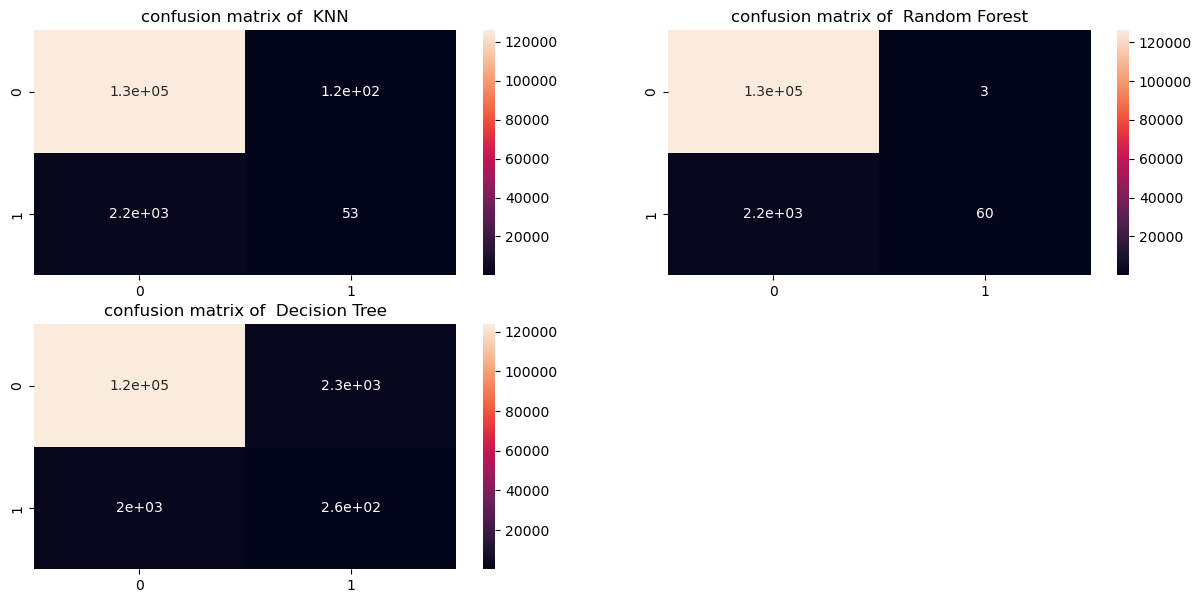

In [44]:
models_predictions=[knn.predict(X_val), rfc.predict(X_val),tree.predict(X_val)]
label={1:'KNN',2:'Random Forest',3:'Decision Tree'}
plt.figure(figsize=(15,7))
for n,model in enumerate(models_predictions,1) :
    cm = confusion_matrix(y_val,model)
    plt.subplot(2,2,n)
    sns.heatmap(cm,annot=True)
    plt.title('confusion matrix of  '+ label[n])

**Compare Model**

In [ ]:
models = pd.DataFrame({
    'Model': [ 'KNN', 'Random Forest','Decision Tree'
              ],
    'Akurasi': [metrics.accuracy_score(knn.predict(X_val), y_val) * 100, metrics.accuracy_score(rfc.predict(X_val), y_val) * 100, 
              metrics.accuracy_score(tree.predict(X_val), y_val) * 100
              ],
    'AUC Skor' : [knn_auc,rfc_auc,tree_auc]
    })
models.sort_values(by='Akurasi', ascending=False).style.background_gradient(cmap='Reds')

**ROC AUC Curve**

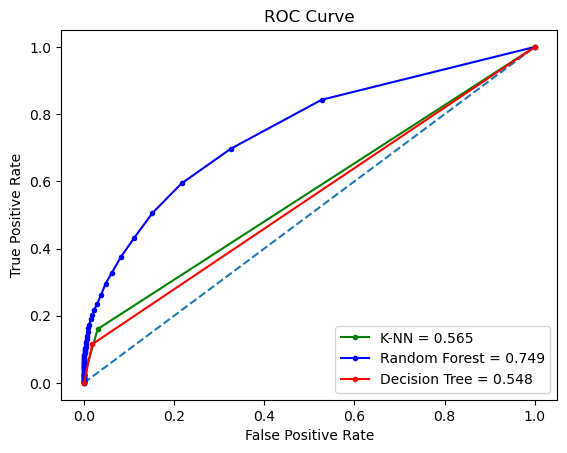

In [45]:
#ROC CURVE
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(knn_fpr, knn_tpr, 'g', marker='.', label = 'K-NN = %0.3f' % knn_auc)
plt.plot(rfc_fpr, rfc_tpr, 'b', marker='.', label = 'Random Forest = %0.3f' % rfc_auc )
plt.plot(tree_fpr, tree_tpr, 'r', marker='.',label = 'Decision Tree = %.3f' % tree_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Kurva ROC dan nilai AUC menunjukkan kemampuan model untuk memprediksi, semakin tinggi nilai AUC maka semakin baik model tersebut dalam memprediksi dan sebaliknya. Sehingga model Random Forest memiliki performa yang lebih baik dibandingkan dengan model lainnya yaitu dengan nilai AUC = 74,9%.